First we import the data.  At first we need the SNP summary statistics and the genome mapping file.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame
from scipy.stats import uniform
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import ndex2
import ndex2.client as nc
#import genepattern
import networkx as nx


File Format: SNP-level p-values
This file is a 4-column delimited file with the following columns in this order:

rsID
Chromosome
SNP Position (using the genome build corresponding to your Gene Positions file)
SNP P-value
The user may pass more columns than specified (as long as the file has at least 4 columns). The default behavior will be to select the first four columns in order as these columns.

The user may specify the columns to use in the file by passing in a 4-valued list indicating the column numbers that should be used (in the same order as the one described above) into the 'cols' parameter. These 4 values will be indexed from 0 (e.g. '0,1,2,3' will select the first 4 columns in order), and must be passed as a comma-separated string (no spaces).

In [2]:
# Fix so that this reads directly from respository Data folder
#snp_summary_file = '/Users/Dan/data/GWAS_for_class/pgc.bip.2012-04/pgc.bip.full.2012-04.txt'
snp_summary_file = '/Users/Dan/data/GWAS_for_class/pgc.scz.full.2012-04.txt'

def load_SNP_pvals(snp_pval_file, delimiter='\t', header=False, cols='0,1,2,3'):
        # Check for valid 'cols' parameter
    try:
        cols_idx = [int(c) for c in cols.split(',')]
    except:
        raise ValueError('Invalid column index string')
    # Load gene_pos_file
    if header:
            SNP_summary = pd.read_csv(snp_pval_file, delimiter=delimiter)
    else:
            SNP_summary = pd.read_csv(snp_pval_file, delimiter=delimiter, header=-1)
    # Check gene positions table format
    if (SNP_summary.shape[1] < 4) | (max(cols_idx) >  SNP_summary.shape[1]-1):
        raise ValueError('Not enough columns in SNP Summary File')
    # Construct gene position table
    SNP_summary = SNP_summary[cols_idx]
    SNP_summary.columns = ['Marker', 'Chr', 'Pos', 'P-Value']
    return SNP_summary

snp_summary = load_SNP_pvals(snp_summary_file, delimiter='\t', header=False, cols='0,1,2,7')
snp_summary.head()

,Marker,Chr,Pos,P-Value
0,rs3131972,1,742584,0.761033
1,rs3131969,1,744045,0.784919
2,rs3131967,1,744197,0.793520
3,rs1048488,1,750775,0.761041
4,rs12562034,1,758311,0.987899


Assigning GWAS p-values to genes - Minimum P Method
For each gene in the genome (or as defined by the Gene Positions file), we will collect all SNPs within a specified genomic distance from the gene body (transcription start site to transcription end site). The SNP must fall within the specified genomic distance (up or downstream of the gene body). This distance is given as kilobases, (e.g. if 'window' is set to 5, this will collect all SNPs within 5kb of the gene body.
Each gene is then assigned the minimum of all the p-values across all SNPs falling within the specified window.

In [4]:
def min_p(SNP_summary, gene_positions, window):
        starttime = time.time()
        dist = window*1000
        genelist = list(gene_positions.index)
        min_p_list = []
        SNP_summary['Chr']=SNP_summary['Chr'].astype(str)
        for gene in genelist:
                gene_info = gene_positions.ix[gene]
                chrom = str(gene_info['Chr'])
                start = gene_info['Start']
                stop = gene_info['End']
                # Get all SNPs on same chromosome
                SNP_summary_filt1 = SNP_summary[SNP_summary['Chr']==chrom]
                # Get all SNPs after window start position
                SNP_summary_filt2 = SNP_summary_filt1[SNP_summary_filt1['Pos'] >= (start-dist)]
                # Get all SNPs before window end position
                SNP_summary_filt3 = SNP_summary_filt2[SNP_summary_filt2['Pos'] <= (stop+dist)]
                # Get min_p statistics for this gene
                if len(SNP_summary_filt3) >= 1:
                        min_p_data = SNP_summary_filt3.ix[SNP_summary_filt3['P-Value'].argmin()]
                        min_p_list.append([gene, chrom, start, stop, SNP_summary_filt3.shape[0], min_p_data['Marker'], int(min_p_data['Pos']), min_p_data['P-Value']])
                else:
                        min_p_list.append([gene, chrom, start, stop, 0, None, None, None])
        min_p_table = pd.DataFrame(min_p_list, columns = ['Gene', 'Chr', 'Gene Start', 'Gene End', 'nSNPs', 'TopSNP', 'TopSNP Pos', 'TopSNP P-Value'])
        min_p_table['SNP Distance'] = abs(min_p_table['TopSNP Pos'].subtract(min_p_table['Gene Start']))
        min_p_table = min_p_table.dropna().sort_values(by=['TopSNP P-Value', 'Chr', 'Gene Start'])
        print("P-Values assigned to genes:", time.time()-starttime, 'seconds')
        return min_p_table

In [7]:
# Load gene positions from file                                                                                            
def load_gene_pos(gene_pos_file, delimiter='\t', header=False, cols='0,1,2,3'):
        # Check for valid 'cols' parameter                                                                                 
        try:
                cols_idx = [int(c) for c in cols.split(',')]
        except:
                raise ValueError('Invalid column index string')
        # Load gene_pos_file                                                                                               
        if header:
                gene_positions = pd.read_csv(gene_pos_file, delimiter=delimiter)
        else:
                gene_positions = pd.read_csv(gene_pos_file, delimiter=delimiter, header=-1)
        # Check gene positions table format                                                                                
        if (gene_positions.shape[1] < 4) | (max(cols_idx) >  gene_positions.shape[1]-1):
                raise ValueError('Not enough columns in Gene Positions File')
        # Construct gene position table                                                                                    
        gene_positions = gene_positions[cols_idx]
        gene_positions.columns = ['Gene', 'Chr', 'Start', 'End']
        return gene_positions.set_index('Gene')

In [9]:
gene_pos_file = '/Users/Dan/data/GWAS_for_class/hg18/glist-hg18_proteinCoding.txt'

hg18_gene_pos = load_gene_pos(gene_pos_file, delimiter='\t', header=False)

min_p_table = min_p(snp_summary, hg18_gene_pos, 10)
min_p_table.head()



/Users/Dan/anaconda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/Dan/anaconda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/Dan/anaconda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


KeyboardInterrupt: 

Write the gene-wise p-values to a file

Propagate the -log10(p-value) of each gene across the actual network and the null networks.

First, we are going to grab the appropriate NDEX network.  In this case we are defaulting to PCNet, found at
http://www.ndexbio.org/#/network/f93f402c-86d4-11e7-a10d-0ac135e8bacf



In [4]:
#min_p_table.to_csv('/Users/Dan/data/GWAS_for_class/scz_gene_10k.txt',sep='\t')

min_p_table=pd.read_csv('/Users/Dan/data/GWAS_for_class/scz_gene_10k.txt', sep='\t',usecols=[1,2,3,4,5,6,7,8,9])
min_p_table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
0,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
1,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
2,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
3,HIST1H2AL,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
4,HIST1H1B,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


In [5]:
def manhattan_plot(df):
    
    # -log_10(pvalue)
    df['minuslog10pvalue'] = -np.log10(df['TopSNP P-Value'])
    df['Chr'] = df['Chr'].astype('category')
    #df.chromosome = df.chromosome.cat.set_categories(['ch-%i' % i for i in range(12)], ordered=True)
    df = df.sort_values(['Chr','Gene Start'])

    # How to plot gene vs. -log10(pvalue) and colour it by chromosome?
    df['ind'] = range(len(df))
    df_grouped = df.groupby(('Chr'))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = ['red','green','blue', 'yellow']
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='minuslog10pvalue',color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([0, len(df)])
    ax.set_ylim([0, 10])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-Log10 p-value')
    plt.show()

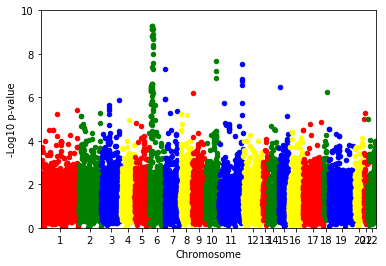

In [6]:
manhattan_plot(min_p_table)


In [7]:

from scipy.sparse import coo_matrix,csc_matrix
from scipy.sparse.linalg import expm, expm_multiply



anon_ndex=nc.Ndex2("http://public.ndexbio.org")
network_niceCx = ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='f93f402c-86d4-11e7-a10d-0ac135e8bacf')


print(network_niceCx.get_summary())

Name: Parsimonious Composite Network (PCNet)
Nodes: 19781
Edges: 2724724
Node Attributes: 0
Edge Attributes: 0



In [8]:
#networkx

G=network_niceCx.to_networkx()

node_names = [G.node[n]['name'] for n in G.nodes()]
#graph laplacian
L=csc_matrix(nx.laplacian_matrix(G))


In [9]:
#in this branch of the code we compute based on a pre-calculated kernel
# First, we will load the network kernel of the network we will be using
kernel = pd.read_hdf('/Users/Dan/Data/GWAS_for_class/kernels/PCNet_kernel.hdf')
network_genes = list(kernel.index)

#We can load the data, but its already in memory
#min_p_table = pd.read_csv('/Users/Dan/Data/GWAS_for_class/scz_gene_10k.txt',sep='\t', usecols=[1,2,3,4,5,6,7,8])
min_p_table.columns = list(min_p_table.columns)

#Find genes with p-values below the threshold
name='prop'
threshold = 5e-6
threshold_genes = {}
prop_vectors = []
pval_table = min_p_table
threshold_genes[name] = min_p_table[pval_table['TopSNP P-Value'] < threshold]
prop_vector = (pval_table.set_index('Gene').loc[network_genes]['TopSNP P-Value'] < threshold).astype(float)
prop_vector.name = name
prop_vectors.append(prop_vector)
prop_vector_matrix = pd.concat(prop_vectors, axis=1).ix[network_genes].T

/Users/Dan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/Dan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [10]:
#propagate with pre-computed kernel
prop_val_matrix = np.dot(prop_vector_matrix, kernel)
prop_val_table = pd.DataFrame(prop_val_matrix, index = prop_vector_matrix.index, columns = prop_vector_matrix.columns)
prop_val_table.T.sort_values(by='prop', ascending=False).head()

,prop
Gene,
TCF4,0.479835
HIST1H4C,0.467925
HIST1H2BC,0.467749
HIST1H2BN,0.466517
HIST1H4J,0.466316


In [11]:
#or, heat diffusion, not precomputed, takes a minute or so

input_list=list(pval_table[pval_table['TopSNP P-Value'] < threshold]['Gene'])
input_vector=np.array([n in input_list for n in node_names])
out_vector=expm_multiply(-L,input_vector,start=0,stop=0.1,endpoint=True)[-1]

out_dict= dict(zip(node_names, out_vector))
out_dict= {'prop': out_vector,'Gene':node_names}
heat_df=pd.DataFrame.from_dict(out_dict).set_index('Gene')
heat_df.sort_values(by='prop', ascending=False).head()


,prop
Gene,
LY6G6F,0.744055
MUSTN1,0.742368
AGBL3,0.616114
PATE1,0.501521
ZSCAN23,0.080481


In [12]:
#write the results out

prop_val_table.T.sort_values(by='prop', ascending=False).to_csv('propagated.txt', sep='\t')

In [13]:
#evaluation section

wd = '/Users/Dan/Data/GWAS_for_class/'

train_raw_pval_table = pd.read_csv('/Users/Dan/Data/GWAS_for_class/scz_gene_10k.txt',sep='\t', usecols=[1,2,3,4,5,6,7,8])
train_raw_pval_table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value
0,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10
1,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10
2,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10
3,HIST1H2AL,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10
4,HIST1H1B,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10


In [14]:
#test set gene mapped data
test_raw_pval_table = pd.read_csv('/Users/Dan/Data/GWAS_for_class/scz2_gene_10k.txt',sep='\t', usecols=[1,2,3,4,5,6,7,8])
test_raw_pval_table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value
0,A1BG,chr19,58861959,58864495,41,rs11668660,58873584.0,0.123100
1,A1CF,chr10,52595833,52645435,105,rs149129397,52591486.0,0.037540
2,A2M,chr12,9267753,9268613,46,rs56256934,9265319.0,0.037850
3,A2ML1,chr12,9020538,9039597,204,rs142115174,9044945.0,0.003994
4,A3GALT2,chr1,33772366,33786699,107,rs149266061,33771312.0,0.005271


In [15]:
#here is the propagated data
train_prop_table = pd.read_csv('/Users/Dan/data/GWAS_for_class/GWAB_webserver/genelist_scz1_complete_for_class_analyis.txt',sep='\t')
train_prop_table.head()


,Gene,prop
0,UBC,140.205768
1,APP,90.724654
2,HSP90AA1,52.349093
3,HSP90AB1,49.868157
4,SUMO2,46.114665


In [16]:
def intersection_l(lst1, lst2):
    return list(set(lst1) & set(lst2))

int1=intersection_l(list(train_prop_table['Gene']),list(train_raw_pval_table['Gene']))
int2= intersection_l(int1,list(train_raw_pval_table['Gene']))


intersection=pd.DataFrame({'Gene':int2})
intersection.head()

gene_number=len(int2)


In [17]:
#we can look at the intersection of the top of any two lists

train_prop_table_ltd=train_prop_table.set_index('Gene').join(intersection.set_index('Gene'),lsuffix='_tr_prop',rsuffix='_int',how='right')
train_raw_pval_table_ltd=train_raw_pval_table.set_index('Gene').join(intersection.set_index('Gene'),lsuffix='_tr',rsuffix='_int',how='right')
test_raw_pval_table_ltd=test_raw_pval_table.set_index('Gene').join(intersection.set_index('Gene'),lsuffix='_test',rsuffix='_int',how='right')


In [20]:
train_raw_top100=train_raw_pval_table_ltd.sort_values(by='TopSNP P-Value')[0:1000].index.values
test_raw_top100=test_raw_pval_table_ltd.sort_values(by='TopSNP P-Value')[0:1000].index.values
train_prop_top100=train_prop_table_ltd.sort_values(by='prop',ascending=False)[0:1000].index.values

In [21]:
len(intersection_l(train_raw_top100,test_raw_top100))

323

In [22]:
len(intersection_l(train_prop_top100,test_raw_top100))

108

In [23]:
len(intersection_l(train_prop_top100,train_raw_top100))

146

In [24]:
#alternatively, we can look at a gold standard gene set

gold_std=pd.read_csv('/Users/Dan/Data/GWAS_for_class/SZ/SZ_hugo.txt',sep='\t', header=None)
gold_std.head()

,0,1
0,50,ACO2
1,60,ACTB
2,71,ACTG1
3,116,ADCYAP1
4,133,ADM


In [25]:
genes=list(gold_std[1])

len(intersection_l(train_prop_top100,gold_std[1]))

162

In [26]:
len(intersection_l(train_raw_top100,gold_std[1]))

84

In [27]:
len(intersection_l(test_raw_top100,gold_std[1]))

94

In [28]:
#in this case the evaluation is a hypergeometric

import scipy.stats as stats
#M=total genes
#n=size of gold std
#N=size of pull, in this case 1000
#x=hits

#propagated value
x_prop=len(intersection_l(train_prop_top100,gold_std[1]))
M=len(int2)
n=len(gold_std[1])
N=1000
prb = stats.hypergeom.cdf(x_prop, M, n, N)
prop_p=1-prb
prop_p

8.886003044494828e-12

In [29]:
#raw GWAS comparison

x_raw=len(intersection_l(train_raw_top100,gold_std[1]))
prb = stats.hypergeom.cdf(x_raw, M, n, N)
raw_p=1-prb
raw_p

0.18380591128880164

In [ ]:
#create the network for export

prop_val_sorted=prop_val_table.T.sort_values(by='prop', ascending=False)

for n in network_niceCx.get_nodes():
    try:
        network_niceCx.set_node_attribute(n[0],'propogated score', prop_val_sorted.loc(n['name'])['prop'])
    except KeyError:
        next
    
        

In [ ]:
[n['name'] for n in network_niceCx.get_nodes()]